In [138]:
import math
import re
import string

import nltk
import pandas as pd
from langdetect import detect
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

data = pd.read_csv('Datafiniti_Hotel_Reviews_Jun19.csv', encoding='ISO-8859-1', sep=',')
head = data.head()
info = data.info()
describe = data.describe()
data.shape
#head, info, describe

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    10000 non-null  object 
 1   dateAdded             10000 non-null  object 
 2   dateUpdated           10000 non-null  object 
 3   address               10000 non-null  object 
 4   categories            10000 non-null  object 
 5   primaryCategories     10000 non-null  object 
 6   city                  10000 non-null  object 
 7   country               10000 non-null  object 
 8   keys                  10000 non-null  object 
 9   latitude              10000 non-null  float64
 10  longitude             10000 non-null  float64
 11  name                  10000 non-null  object 
 12  postalCode            10000 non-null  object 
 13  province              10000 non-null  object 
 14  reviews.date          10000 non-null  object 
 15  reviews.dateAdded   

(10000, 26)

In [139]:
data = data[['reviews.rating', 'reviews.text', 'reviews.title']]
data['reviews.text'] = data['reviews.title'] + " " + data['reviews.text']
data.shape

(10000, 3)

In [140]:
data = data.drop_duplicates()
data = data.dropna()
data.shape

(9786, 3)

In [141]:
import matplotlib.pyplot as plt

def detect_lang(text):
    try:
        return detect(text)
    except:
        return "error"


data['lang'] = data['reviews.text'].apply(lambda x: detect_lang(x))
data = data.loc[data['lang'] == 'en']
data['lang'].value_counts()
data.shape

(9768, 4)

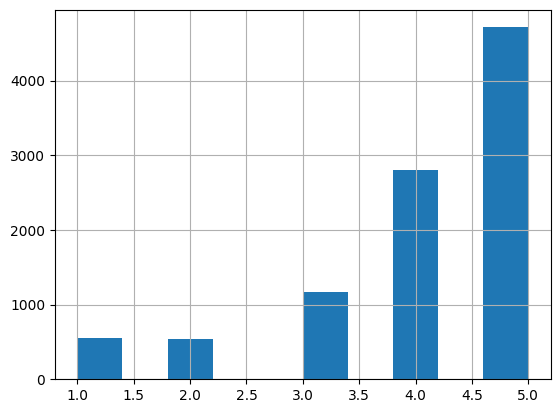

In [142]:
data['reviews.rating'].hist()
plt.show()

In [143]:
#afficher le nombre de commentaire avec une note 0
data.loc[data['reviews.rating'] == 1].shape

(555, 4)

In [144]:
#afficher le nombre de commentaire avec une note 5
data.loc[data['reviews.rating'] == 5].shape

(4713, 4)

In [145]:
data['reviews.rating'] = data['reviews.rating'].apply(lambda x: x - 5 if x > 5 else x)
data['reviews.rating'] = data['reviews.rating'].apply(lambda x: math.floor(x))
data.loc[data['reviews.rating'] == 1].shape, data.loc[data['reviews.rating'] == 5].shape

((555, 4), (4713, 4))

In [146]:
nltk.download('stopwords')
en_stopwords = nltk.corpus.stopwords.words('english')
ps = nltk.PorterStemmer()


def clean_text(text):
    result = "".join([word for word in text if word not in string.punctuation])
    tokens = re.split('\W+', result)
    text = [ps.stem(word) for word in tokens if word not in en_stopwords]
    return text

<>:8: SyntaxWarning: invalid escape sequence '\W'
<>:8: SyntaxWarning: invalid escape sequence '\W'
/var/folders/l1/c9cqs1hx4vx2w36p7pg1dhq80000gn/T/ipykernel_6773/4066190274.py:8: SyntaxWarning: invalid escape sequence '\W'
  tokens = re.split('\W+', result)
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/pieroneri/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [147]:
positive_com = data[data['reviews.rating'] == 5]['reviews.text']
negative_com = data[data['reviews.rating'] == 1]['reviews.text']
positive_com.head(), negative_com.head()

(3     Very good Not cheap but excellent location. Pr...
 8                   Location Location Location MoreMore
 10    Beautiful hotel This is a new Hampton Inn and ...
 12    Under construction and extremely accomodating ...
 14    Excellent hotel Great staff and rooms. Houseke...
 Name: reviews.text, dtype: object,
 6     Does not live up to its reputation We recently...
 7     worst customer service ever I reserved a room ...
 9     The worst place i've booked Hello, I have trav...
 26    Horrible, closet like rooms with no air condit...
 30    In the valet parking they stole in the car. Un...
 Name: reviews.text, dtype: object)

In [148]:
sample_positive_text = " ".join(text for text in positive_com.sample(frac=0.1, random_state=23))
sample_negative_text = " ".join(text for text in negative_com.sample(frac=0.1, random_state=23))


In [149]:
wordcloud_positive = WordCloud(width=1600, height=800, max_words=200, background_color="white").generate(sample_positive_text)
wordcloud_negative = WordCloud(width=1600, height=800, max_words=200, background_color="white").generate(sample_negative_text)
plt.figure(figsize=(15, 7.5))

<Figure size 1500x750 with 0 Axes>

<Figure size 1500x750 with 0 Axes>

(-0.5, 1599.5, 799.5, -0.5)

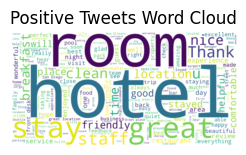

In [150]:
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.title('Positive Tweets Word Cloud')
plt.axis("off")

(-0.5, 1599.5, 799.5, -0.5)

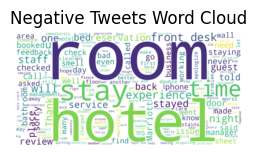

In [151]:
plt.subplot(1, 2, 2)
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.title('Negative Tweets Word Cloud')
plt.axis("off")

In [152]:
plt.show()

In [153]:
#get all 5 stars comments and 1 star comments
positive_sample = data[data['reviews.rating'] == 5].sample(frac=1, random_state=23)
negative_sample = data[data['reviews.rating'] == 1].sample(frac=1, random_state=23)

balanced_sample = pd.concat([positive_sample, negative_sample])
balanced_sample['reviews.rating'].value_counts()


reviews.rating
5    4713
1     555
Name: count, dtype: int64

In [154]:
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

In [155]:
vectorizer = TfidfVectorizer(max_features=10000, analyzer=clean_text)
X_train, X_val, y_train, y_val = train_test_split(data['reviews.text'], data['reviews.rating'], test_size=0.2, random_state=23)

X_train_vectorized = vectorizer.fit_transform(X_train)
X_val_vectorized = vectorizer.transform(X_val)

X_train_vectorized = X_train_vectorized.todense()
X_val_vectorized = X_val_vectorized.todense()

In [156]:
encoder = LabelEncoder()
y_train_encoded = to_categorical(encoder.fit_transform(y_train))
y_val_encoded = to_categorical(encoder.transform(y_val))

In [157]:
from keras.layers import Input

model = Sequential()
model.add(Input(shape=(X_train_vectorized.shape[1],)))
model.add(Dense(512, activation='relu'))
model.add(Dense(5, activation='softmax'))  # 2 because we have two classes
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [158]:
history = model.fit(X_train_vectorized, y_train_encoded, epochs=10, batch_size=64, 
                    validation_data=(X_val_vectorized, y_val_encoded), verbose=1)


Epoch 1/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.4920 - loss: 1.2574 - val_accuracy: 0.6259 - val_loss: 0.8811
Epoch 2/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.7227 - loss: 0.7044 - val_accuracy: 0.6484 - val_loss: 0.8285
Epoch 3/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.8609 - loss: 0.4437 - val_accuracy: 0.6192 - val_loss: 0.9064
Epoch 4/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.9251 - loss: 0.2750 - val_accuracy: 0.6018 - val_loss: 1.0185
Epoch 5/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.9736 - loss: 0.1481 - val_accuracy: 0.5977 - val_loss: 1.1309
Epoch 6/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.9874 - loss: 0.0839 - val_accuracy: 0.5885 - val_loss: 1.2634
Epoch 7/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.9977 - loss: 0.0439 - val_accuracy: 0.5860 - val_loss: 1.3693
Epoch 8/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.9995 - loss: 0.0242 - val_accu

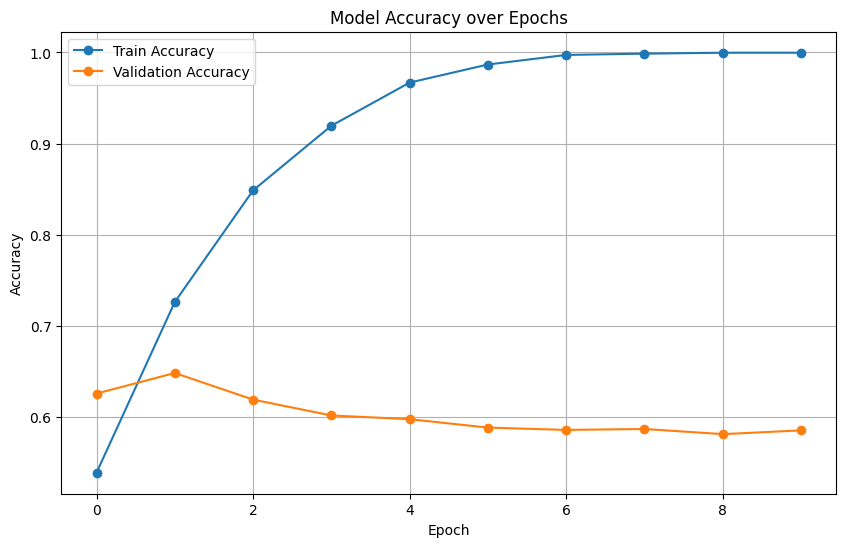

In [159]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Model Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()